In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
%cd /content/gdrive/MyDrive/2022_Summer_School

/content/gdrive/MyDrive/2022_Summer_School


In [6]:
!ls

Conditional_GAN_implementation.ipynb  Pbm1_Airfoil_CGAN.ipynb
Conditional_GAN_Wasserstein.ipynb     Presentation
data				      singularity_SU2.ipynb


In [7]:
import torch
from torchvision import transforms, datasets
import torch.nn as nn
from torch import optim as optim

import numpy as np
import os, json

from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
class GeneratorModel(nn.Module):
    def __init__(self):
        super(GeneratorModel, self).__init__()
        input_dim = 5 + 3 #noise + input parameters
        output_dim = 192*2 #fake airfoils
        
        #this is another network
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
    
    def forward(self, z, design_paras):
        x = torch.cat([z, design_paras], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)
        return output.to(device)

In [10]:
class DiscriminatorModel(nn.Module):
    def __init__(self):
        super(DiscriminatorModel, self).__init__()
        input_dim = 192*2 + 3
        output_dim = 1

        #one network for the airfoils (fake and real)
        self.hidden_layer1 = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        self.hidden_layer4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x, design_paras):
        x = torch.cat([x, design_paras], 1)
        output = self.hidden_layer1(x)
        output = self.hidden_layer2(output)
        output = self.hidden_layer3(output)
        output = self.hidden_layer4(output)

        return output.to(device)

In [11]:
discriminator = DiscriminatorModel()
generator = GeneratorModel()
discriminator.to(device)
generator.to(device)

GeneratorModel(
  (hidden_layer1): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer2): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer3): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (hidden_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=384, bias=True)
    (1): Tanh()
  )
)

In [12]:
airfoils_np = np.load('/content/gdrive/MyDrive/2022_Summer_School/data/airfoils_opt_995.npy').astype(np.float32) #(995,192,2), Y labels
inp_paras_np = np.load('/content/gdrive/MyDrive/2022_Summer_School/data/inp_paras_995.npy').astype(np.float32) #(995, 3), X labels
# aoas_np = np.load('../data/aoas_opt_995.npy').astype(np.float32).reshape(-1, 1) #(995,), optimal angle
mean_std = (inp_paras_np.mean(0), inp_paras_np.std(0))

#normalization
normalized_inp_paras = (inp_paras_np - mean_std[0]) / mean_std[1]

#split dataset
airfoils_train, airfoils_test, inp_paras_train, inp_paras_test = train_test_split(airfoils_np, normalized_inp_paras, test_size=0.20, random_state=1)


torch.Size([796, 192, 2])


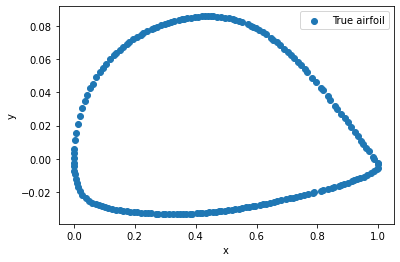

tensor([[ 9.9932e-01, -2.6740e-03],
        [ 9.8683e-01,  1.3985e-04],
        [ 9.8153e-01,  1.4101e-03],
        [ 9.6859e-01,  4.5738e-03],
        [ 9.6072e-01,  6.5273e-03],
        [ 9.5004e-01,  9.1955e-03],
        [ 9.4297e-01,  1.0969e-02],
        [ 9.3289e-01,  1.3502e-02],
        [ 9.2286e-01,  1.6018e-02],
        [ 9.1009e-01,  1.9211e-02],
        [ 8.9890e-01,  2.1994e-02],
        [ 8.8913e-01,  2.4408e-02],
        [ 8.7904e-01,  2.6878e-02],
        [ 8.6580e-01,  3.0085e-02],
        [ 8.5780e-01,  3.2002e-02],
        [ 8.4234e-01,  3.5657e-02],
        [ 8.3318e-01,  3.7786e-02],
        [ 8.1710e-01,  4.1459e-02],
        [ 8.1088e-01,  4.2854e-02],
        [ 7.9510e-01,  4.6327e-02],
        [ 7.8338e-01,  4.8839e-02],
        [ 7.6675e-01,  5.2301e-02],
        [ 7.5906e-01,  5.3859e-02],
        [ 7.4753e-01,  5.6141e-02],
        [ 7.3583e-01,  5.8385e-02],
        [ 7.2331e-01,  6.0706e-02],
        [ 7.1295e-01,  6.2558e-02],
        [ 7.0248e-01,  6.436

In [22]:
#example airfoil
print(airfoils_train.shape)
plt.scatter(airfoils_train[0,:,0], airfoils_train[0,:,1],label ='True airfoil')
plt.xlabel('x')
plt.ylabel('y')
plt.legend() 
plt.show()
print(airfoils_train[0])

In [14]:
inp_paras_train = torch.tensor(inp_paras_train, device=device, dtype=torch.float)
print(inp_paras_train.shape)
# airfoils_train = torch.tensor(airfoils_train.transpose((0, 2, 1)), device=device, dtype=torch.float) #？？？
airfoils_train = torch.tensor(airfoils_train, device=device, dtype=torch.float)

print(airfoils_train.shape)
# aoas_opt = torch.tensor(aoas_opt, device=device, dtype=torch.float).reshape(-1, 1)
# inp_mean = torch.tensor(0, dtype=torch.float, device=device)
# inp_std = torch.tensor(1, dtype=torch.float, device=device)
# print(airfoils_train.shape)

inp_paras_test = torch.tensor(inp_paras_test, device=device, dtype=torch.float)
print(inp_paras_test.shape)
# airfoils_train = torch.tensor(airfoils_train.transpose((0, 2, 1)), device=device, dtype=torch.float) #？？？
airfoils_test = torch.tensor(airfoils_test, device=device, dtype=torch.float)

print(airfoils_test.shape)

torch.Size([796, 3])
torch.Size([796, 192, 2])
torch.Size([199, 3])
torch.Size([199, 192, 2])


In [15]:
batch_size = 16

#training data
train_dataset = TensorDataset(airfoils_train, inp_paras_train) #Y and X
data_loader = DataLoader(train_dataset, batch_size=batch_size)


In [16]:
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

# torch.ones(batch_size, dtype = torch.long)

GAN
E_x[log (D(x))] + E_z[log (1 — D(G(z)))]

Conditional GAN
E_x[log (D(x|y))] + E_z[log (1 — D(G(z|y)))]

In [17]:
n_epochs = 500
for epoch_idx in range(n_epochs):
    G_loss = []
    D_loss = []
    for batch_idx, data_input in enumerate(data_loader):
        noise = torch.randn(batch_size, 5).to(device)
        fake_paras = torch.randn(batch_size, 3).to(device)
        generated_airfoil = generator(noise, fake_paras) #batch size * 384
        # print(generated_airfoil.shape)

        # Discriminator
        # print(f"data_input[0]:{data_input[0].shape}") #batch size * 192 * 2
        true_airfoil = data_input[0].view(batch_size, -1).to(device) 
        if true_airfoil.shape[1] == 192*2:
          true_design_paras = data_input[1].to(device) # batch_size
          true_labels = torch.ones(batch_size).to(device)
          
          discriminator_optimizer.zero_grad()

          discriminator_output_for_true_airfoil = discriminator(true_airfoil, true_design_paras).view(batch_size)
          true_discriminator_loss = loss(discriminator_output_for_true_airfoil, true_labels)

          discriminator_output_for_generated_airfoil = discriminator(generated_airfoil.detach(), fake_paras).view(batch_size)
          generator_discriminator_loss = loss(discriminator_output_for_generated_airfoil, torch.zeros(batch_size).to(device))
          discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
          
          discriminator_loss.backward()
          discriminator_optimizer.step()

          D_loss.append(discriminator_loss.data.item())
          
          # Generator

          generator_optimizer.zero_grad()

          # It's a choice to generate the data again
          generated_airfoil = generator(noise, fake_paras) 
          discriminator_output_on_generated_airfoil = discriminator(generated_airfoil, fake_paras).view(batch_size)
          generator_loss = loss(discriminator_output_on_generated_airfoil, true_labels)
          generator_loss.backward()
          generator_optimizer.step()
          
          G_loss.append(generator_loss.data.item())


    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch_idx), n_epochs, torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))
    

[0/500]: loss_d: 0.638, loss_g: 0.941
[1/500]: loss_d: 0.315, loss_g: 1.792
[2/500]: loss_d: 0.433, loss_g: 2.248
[3/500]: loss_d: 0.602, loss_g: 1.479
[4/500]: loss_d: 0.270, loss_g: 3.680
[5/500]: loss_d: 0.485, loss_g: 2.620
[6/500]: loss_d: 0.599, loss_g: 3.187
[7/500]: loss_d: 0.536, loss_g: 1.983
[8/500]: loss_d: 0.590, loss_g: 1.944
[9/500]: loss_d: 0.841, loss_g: 1.264
[10/500]: loss_d: 0.639, loss_g: 1.436
[11/500]: loss_d: 0.623, loss_g: 0.935
[12/500]: loss_d: 0.583, loss_g: 1.358
[13/500]: loss_d: 0.606, loss_g: 1.633
[14/500]: loss_d: 0.725, loss_g: 1.124
[15/500]: loss_d: 0.678, loss_g: 0.786
[16/500]: loss_d: 0.658, loss_g: 1.535
[17/500]: loss_d: 0.653, loss_g: 1.192
[18/500]: loss_d: 0.664, loss_g: 1.065
[19/500]: loss_d: 0.608, loss_g: 1.377
[20/500]: loss_d: 0.667, loss_g: 1.140
[21/500]: loss_d: 0.661, loss_g: 1.163
[22/500]: loss_d: 0.661, loss_g: 0.903
[23/500]: loss_d: 0.621, loss_g: 1.370
[24/500]: loss_d: 0.698, loss_g: 0.988
[25/500]: loss_d: 0.658, loss_g: 1.

In [18]:
print(len(G_loss))

49


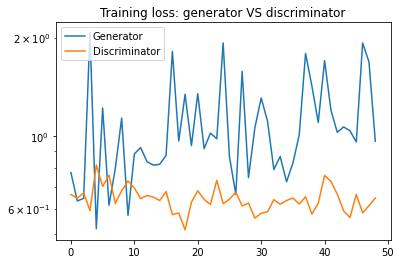

In [19]:
plt.plot(G_loss, label="Generator")
plt.plot(D_loss, label="Discriminator")
plt.legend()
plt.title('Training loss: generator VS discriminator')
plt.yscale('log')
plt.show()

(192, 2)


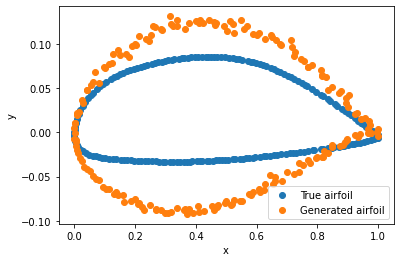

(192, 2)


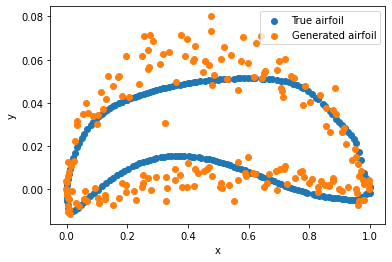

(192, 2)


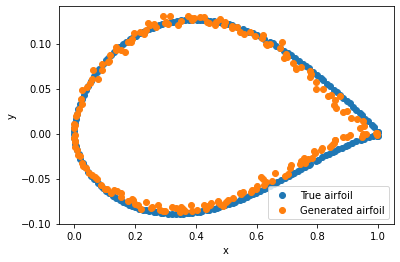

(192, 2)


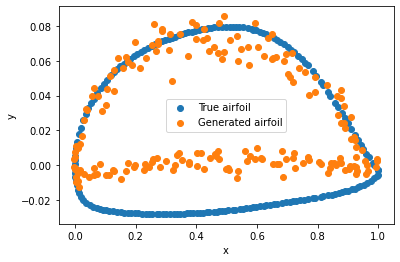

(192, 2)


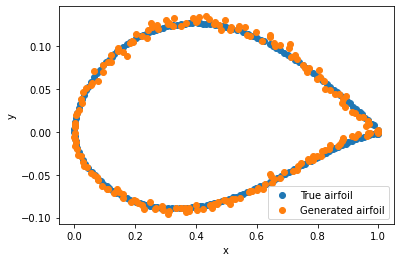

(192, 2)


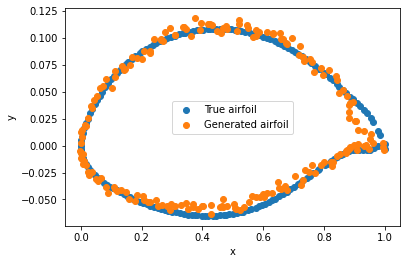

(192, 2)


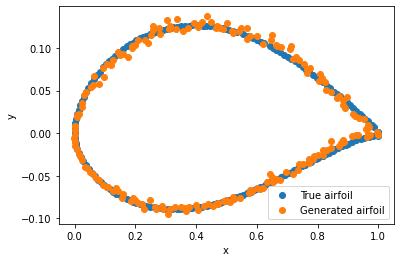

(192, 2)


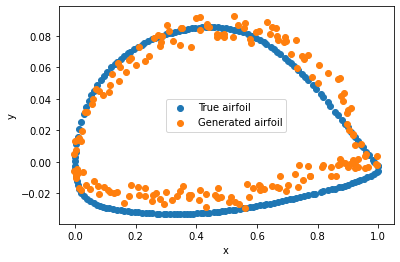

(192, 2)


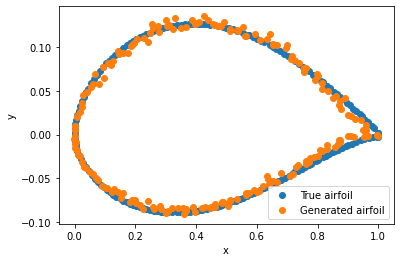

(192, 2)


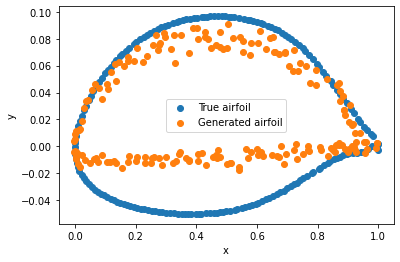

(192, 2)


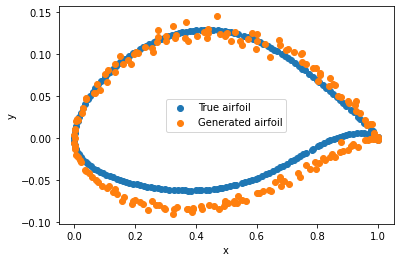

(192, 2)


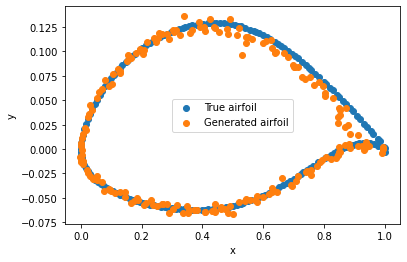

(192, 2)


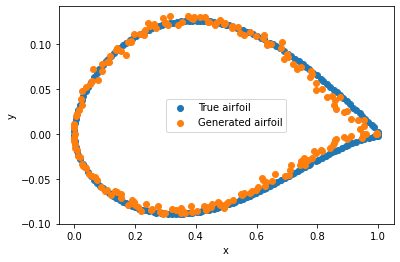

(192, 2)


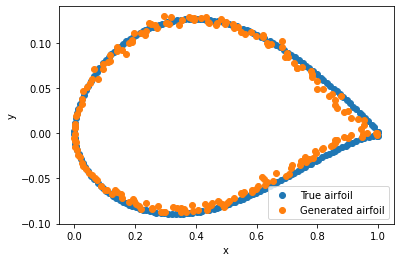

(192, 2)


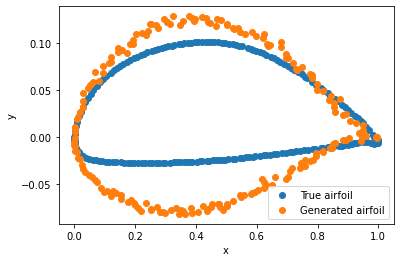

(192, 2)


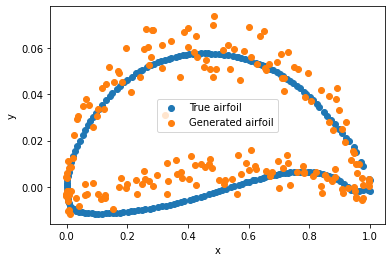

(192, 2)


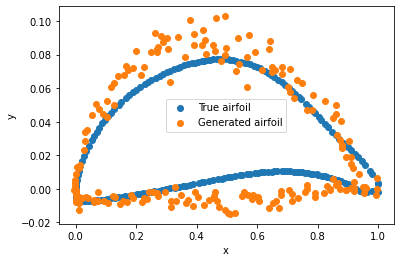

(192, 2)


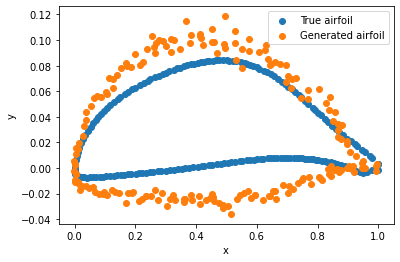

(192, 2)


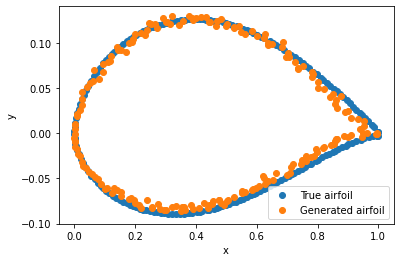

(192, 2)


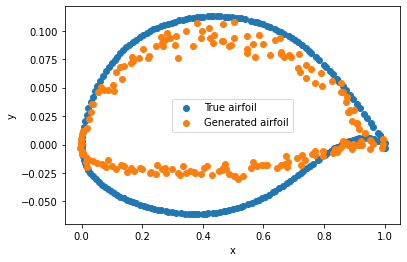

(192, 2)


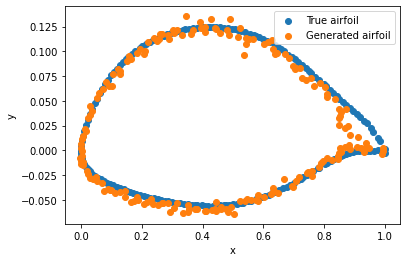

(192, 2)


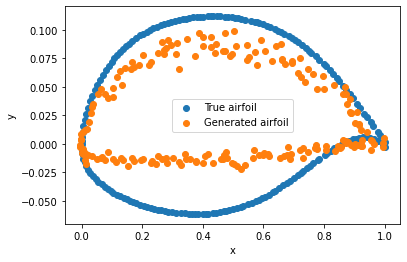

(192, 2)


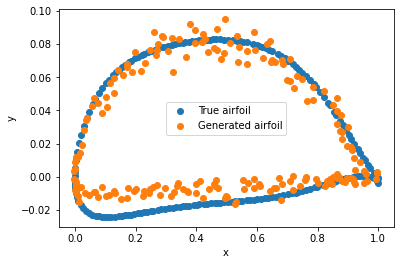

(192, 2)


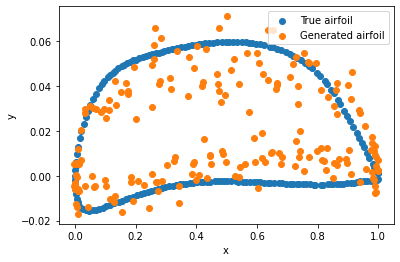

(192, 2)


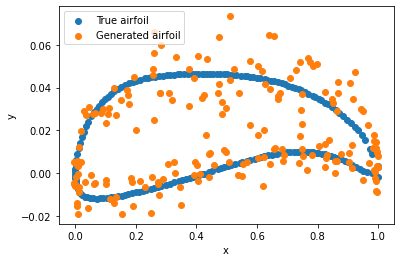

(192, 2)


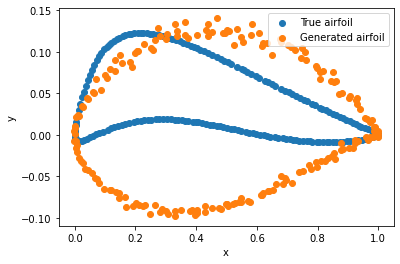

(192, 2)


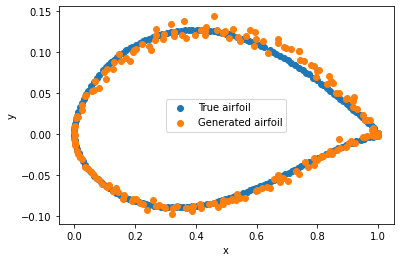

(192, 2)


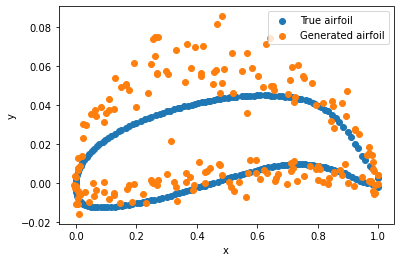

(192, 2)


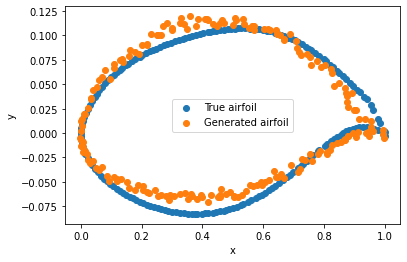

(192, 2)


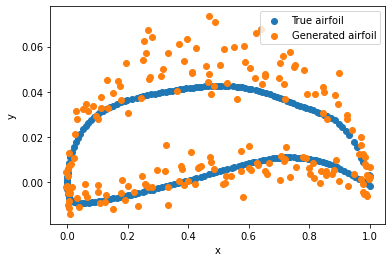

In [21]:
#test data
batch_size_test = 1
test_dataset = TensorDataset(airfoils_test, inp_paras_test)
data_loader_test = DataLoader(train_dataset, batch_size=batch_size_test)

with torch.no_grad():
    noise = torch.randn(batch_size_test, 5).to(device)
    # print(noise)
    for index, test_data in enumerate(data_loader_test):
      if index < 30:
        # print(test_data[1])
        # print(test_data[0][0].view(192,2).shape)
        np_true_airfoil = test_data[0][0].cpu().detach().numpy()
        design_paras_test = test_data[1].to(device)
        generated_airfoil = generator(noise, design_paras_test).cpu().view(batch_size_test, 192, 2)
        # print(generated_airfoil.view(192,2).shape)
        np_gen_airfoil = generated_airfoil.cpu().detach().numpy()
        # print(np_gen_airfoil.shape)
        print(np_gen_airfoil[0].shape)
        #comparison of generated and true airfoils
        plt.scatter(np_true_airfoil[:, 0], np_true_airfoil[:, 1],label ='True airfoil')
        plt.scatter(np_gen_airfoil[0, :, 0], np_gen_airfoil[0, :, 1],label ='Generated airfoil')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend() 
        plt.show()
       